In [12]:
import pandas as pd
import dtale
import pandas_profiling # gera diversas análises de uma só vez
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from IPython.display import Image
%matplotlib inline

In [14]:
# Ler o arquivo
#df = pd.read_csv("amostra_balanceada_dias.csv", sep=',')
df = pd.read_csv("amostra_balanceada_4.csv", sep=';')
#df = pd.read_csv("amostra_balanceada_4_full.csv", sep=';')
features = ["tipo_participacao","nu_produto","co_unidade","nu_produto_isencao"]
features_3 = ["nu_produto","co_unidade","nu_produto_isencao"]
features_2 = ['nu_produto', 'co_unidade']
#features_k = ['nu_produto', 'co_unidade', 'k2', 'k3']
label = ['devolver_tarifa']
#label = ['k2']

#df = df.drop(columns=['Unnamed: 0'])

dataset = pd.DataFrame(data=df,copy=True)
dataset

,tipo_participacao,nu_produto,co_unidade,nu_produto_isencao,devolver_tarifa
0,1,5816,1724,1,1
1,1,4825,9040,8700,1
2,1,952,2464,13,1
3,1,952,2442,13,1
4,2,4616,2405,13,1
...,...,...,...,...,...
16995,2,4616,4189,0,0
16996,2,4616,2296,0,0
16997,2,4616,27,13,1
16998,1,1243,1695,13,1


In [ ]:
# Para instalação do pandas_profiling
# Via conda em https://anaconda.org/conda-forge/pandas-profiling
    # conda install -c conda-forge pandas-profiling

# Via pip em https://pypi.org/project/pandas-profiling/
    # pip install pandas-profiling[notebook]

# Ler o arquivo
df = pd.read_csv("dataset.csv", sep=',', encoding='xxx')
pandas_profiling.ProfileReport(dataset)

In [15]:
dataset_group = dataset.groupby(['nu_produto', 'devolver_tarifa']).count()[['tipo_participacao', 
                                                                            'nu_produto_isencao', 'co_unidade']]
dataset_group

tipo_participacao  nu_produto_isencao  co_unidade
nu_produto devolver_tarifa                                                   
228        0                                1                   1           1
           1                                1                   1           1
305        0                                1                   1           1
355        0                                3                   3           3
           1                                5                   5           5
...                                       ...                 ...         ...
4883       1                               61                  61          61
4937       0                               15                  15          15
           1                                5                   5           5
5816       0                             1804                1804        1804
           1                             2142                2142        2142

[110 rows x 3 columns]

In [16]:
pandas_profiling.ProfileReport(dataset_group)

In [13]:
# Usando o dtale
d = dtale.show(dataset_group)
d.open_browser()

Executing shutdown...


2020-03-12 14:39:34,555 - INFO     - Executing shutdown...


Executing shutdown due to inactivity...


2020-03-12 15:39:34,665 - INFO     - Executing shutdown due to inactivity...


In [ ]:
# Q-Q plots
import scipy.stats as stats

def diagnostic_plots(df, variable):
    for v in variable:
        # define figure size
        plt.figure(figsize=(16, 4))

        # histogram
        plt.subplot(1, 3, 1)
        sns.distplot(df[v], bins=30)
        plt.title('Histogram')

        # Q-Q plot
        plt.subplot(1, 3, 2)
        stats.probplot(df[v], dist="norm", plot=plt)
        plt.ylabel(v+' quantiles')

        # boxplot
        plt.subplot(1, 3, 3)
        sns.boxplot(y=df[v])
        plt.title('Boxplot')

        plt.show()

In [ ]:
diagnostic_plots(dataset, features)

## Definindo limites máximos e mínimos

In [ ]:
def find_boundaries(df, variable, distance):
    # argumento distance: std = 0.1 até 3.0

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

## Delimitando os outliers em co_unidade

## co_unidade

In [ ]:
nu_produto_upper_limit, nu_produto_lower_limit = find_boundaries(dataset, 'co_unidade', 1.35)
nu_produto_upper_limit, nu_produto_lower_limit

In [ ]:
outliers_co_unidade =  np.where(dataset['co_unidade'] > nu_produto_upper_limit, True,
                       np.where(dataset['co_unidade'] < nu_produto_lower_limit, True, False))
dataset['outliers_co_unidade'] = outliers_co_unidade
dataset

In [ ]:
# limpar do dataset somente os outliers

df_trimmed = dataset.loc[~outliers_co_unidade]

dataset.shape, df_trimmed.shape

In [ ]:
diagnostic_plots(df_trimmed, features)

# Amostragem
## Prepara o dataset (sem outliers) para treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

X, y = dataset[features_3], dataset[label]
X_train, X_test, y_train, y_test =\
     train_test_split(X, y,
                      test_size=0.33,
                      random_state=0,
                      stratify=y)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

In [ ]:
from yellowbrick.features import Rank2D
visualizer = Rank2D(algorithm="pearson",  size=(1080, 720))
visualizer.fit_transform(X_train)
visualizer.poof()

In [ ]:
### Juntando features na mesma escala
from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()
X_train_norm = ssc.fit_transform(X_train)
X_test_norm = ssc.transform(X_test)

print(X_train_norm, X_test_norm)

## Modelo linear criado com o objetivo de gerar a função de custo
- Root Mean Square Error (RMSE) é o desvio padrão dos resíduos (erros de previsão). Os resíduos são uma medida de quão longe estão os pontos de dados da linha de regressão;
- RMSE é uma medida de quão espalhados esses resíduos são, em outras palavras, indica a concentração dos dados na linha de melhor ajuste.
- O erro quadrático médio da raiz é comumente usado em análises de climatologia, previsão e regressão para verificar resultados experimentais.

In [ ]:
from sklearn import svm, linear_model
from sklearn.metrics import mean_squared_error

In [ ]:
# Modelo linear criado com o objetivo de gerar a função de custo
model = linear_model.LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
model.score(X_test_norm, y_test)

In [ ]:
y_pred

# Classificação

In [ ]:
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
num_folds = 10
seed = 7
scoring = 'accuracy'

In [ ]:
# Verificação do score de cada algoritmo
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RF', RandomForestClassifier(max_depth=2, random_state=0)))
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

In [ ]:
fig = pyplot.figure()
fig.suptitle('Comparação entre as acurácias')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
# Padronizando o dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(solver='liblinear'))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC(gamma='auto'))])))
results = []
names = []
for name, model in pipelines:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

In [ ]:
fig = pyplot.figure()
fig.suptitle('Escala de Algoritmos - Comparação')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
# RandonFlorest report
from yellowbrick.classifier import ClassificationReport
model_RF =  RandomForestClassifier(max_depth=2, random_state=0)
visualizer = ClassificationReport(model, size=(800, 533))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [ ]:
# Descision Tree CART
from yellowbrick.classifier import ClassificationReport
model_DT =  DecisionTreeClassifier()
visualizer = ClassificationReport(model, size=(800, 533))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [ ]:
# Linear Regression report
from yellowbrick.classifier import ClassificationReport
model_LR =  LogisticRegression(solver='liblinear')
visualizer = ClassificationReport(model, size=(800, 533))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [ ]:
# GaussianNB()
from yellowbrick.classifier import ClassificationReport
model_NB =  GaussianNB()
visualizer = ClassificationReport(model, size=(800, 533))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [ ]:
import eli5
model_RF.fit(X_train, y_train)
eli5.show_weights(model_RF, feature_names = X.columns.tolist())

In [ ]:
from eli5 import show_prediction
model_RF.fit(X_train, y_train)
show_prediction(model_RF, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

In [ ]:
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns.values.tolist(), 
                                                   class_names=y_train)

In [ ]:
predict_fn = lambda x: model_RF.predict_proba(x).astype(float)

In [ ]:
model_RF.fit(X_train, y_train)
exp = explainer.explain_instance(X_test.values[0], predict_fn, num_features=6)
exp.show_in_notebook(show_all=False)

In [ ]:
# Tune scaled KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)

model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

grid_result = grid.fit(rescaledX, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Tune scaled CART
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
max_features = [None, 'sqrt', 'log2']

param_grid = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, max_features=max_features)

model = DecisionTreeClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

grid_result = grid.fit(rescaledX, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC(gamma='auto')

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Ensembles: heurísticas que buscam aumentar a precisão sobre o conjunto de dados
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
results = []
names = []
for name, model in ensembles:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

In [ ]:
# Comparação de Algoritimos
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm - Comparação')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
# Modelo final KNN - Best: 0.543986 using {'n_neighbors': 3}
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_KNN = KNeighborsClassifier(n_neighbors=3)
model_KNN.fit(rescaledX, y_train)

# Estima a acurácia no dataset de validação
rescaledValidationX = scaler.transform(X_test)
predictions = model_KNN.predict(rescaledValidationX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
# Modelo final - Decision Tree CART 
# Best: 0.486831 using {'criterion': 'gini', 'max_depth': 0.15, 'max_features': None, 'splitter': 'best'}
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_DT = DecisionTreeClassifier(criterion='gini', max_depth=0.15, max_features=None, splitter='best')
model_DT.fit(rescaledX, y_train)

# Estima a acurácia no dataset de validação
rescaledValidationX = scaler.transform(X_test)
predictions = model_DT.predict(rescaledValidationX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
# Modelo final SVM - Best: 0.516395 using {'C': 0.3, 'kernel': 'rbf'}
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_SVC = SVC(C=0.3, gamma='auto', kernel='rbf')
model.fit(rescaledX, y_train)

# Estima a acurácia no dataset de validação
rescaledValidationX = scaler.transform(X_test)
predictions = model_SVC.predict(rescaledValidationX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
# Modelo final CART - Best: 0.486831 using {'criterion': 'gini', 'max_depth': 0.15, 'max_features': None, 
#'splitter': 'best'}
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_DT = DecisionTreeClassifier(criterion='gini', max_depth=0.15, max_features=None, splitter='best')
model_DT.fit(rescaledX, y_train)

# Estima a acurácia no dataset de validação
rescaledValidationX = scaler.transform(X_test)
predictions = model_DT.predict(rescaledValidationX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
from sklearn import tree
tree.plot_tree(model_DT.fit(X_test[features_3], y_test[label]))

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(model_DT, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("devolver_tarifa") 

# Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans,MiniBatchKMeans
from scipy.cluster.hierarchy import dendrogram, ward
import matplotlib.cm as cm
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits,load_sample_image
from sklearn.manifold import TSNE,Isomap
from scipy.stats import mode
from sklearn.metrics import accuracy_score,homogeneity_score, completeness_score
%matplotlib inline

/home/marcello/miniconda3/envs/av/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Ler o arquivo
#df = pd.read_csv("amostra_balanceada_dias.csv", sep=',')
df_k = pd.read_csv("amostra_balanceada_4.csv", sep=';')
#df = pd.read_csv("amostra_balanceada_4_full.csv", sep=';')
features = ["tipo_participacao","nu_produto","co_unidade","nu_produto_isencao"]
features_3 = ["nu_produto","co_unidade","nu_produto_isencao"]
features_2a = ['nu_produto', 'co_unidade']
features_2b = ['nu_produto', 'nu_produto_isencao']
features_1 = ['nu_produto']
#features_k = ['nu_produto', 'co_unidade', 'k2', 'k3']
label = ['devolver_tarifa']
#label = ['k2']

dataset_k = pd.DataFrame(data=df_k, copy=True)
dataset_k

,tipo_participacao,nu_produto,co_unidade,nu_produto_isencao,devolver_tarifa
0,1,5816,1724,1,1
1,1,4825,9040,8700,1
2,1,952,2464,13,1
3,1,952,2442,13,1
4,2,4616,2405,13,1
...,...,...,...,...,...
16995,2,4616,4189,0,0
16996,2,4616,2296,0,0
16997,2,4616,27,13,1
16998,1,1243,1695,13,1


In [ ]:
sns.pairplot(df_k)

In [3]:
def find_boundaries(df_k, variable, distance):
    # argumento distance: std = 0.1 até 3.0

    IQR = df_k[variable].quantile(0.75) - df_k[variable].quantile(0.25)

    lower_boundary = df_k[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df_k[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [4]:
co_unidade_upper_limit, co_unidade_lower_limit = find_boundaries(dataset_k, 'co_unidade', 1.35)

print(dataset_k.shape, co_unidade_upper_limit, co_unidade_lower_limit)

(17000, 5) 7604.6 -1630.6000000000004


In [5]:
outliers_co_unidade = np.where(dataset_k['co_unidade'] > co_unidade_upper_limit, True,
                       np.where(dataset_k['co_unidade'] < co_unidade_lower_limit, True, False))

dataset_k['outliers_co_unidade'] = outliers_co_unidade
dataset_k

,tipo_participacao,nu_produto,co_unidade,nu_produto_isencao,devolver_tarifa,outliers_co_unidade
0,1,5816,1724,1,1,False
1,1,4825,9040,8700,1,True
2,1,952,2464,13,1,False
3,1,952,2442,13,1,False
4,2,4616,2405,13,1,False
...,...,...,...,...,...,...
16995,2,4616,4189,0,0,False
16996,2,4616,2296,0,0,False
16997,2,4616,27,13,1,False
16998,1,1243,1695,13,1,False


In [6]:
dataset_k_trimmed = dataset_k.loc[~outliers_co_unidade]

dataset_k.shape, dataset_k_trimmed.shape

((17000, 6), (15856, 6))

In [ ]:
dataset_k_trimmed

## Dendogram

In [ ]:
def display_dendogram(data,p=30):
    dendrogram(ward(data),p=p,truncate_mode='lastp')
    plt.xlabel("Sample number")
    plt.ylabel("Cluster distance")

In [ ]:
features

In [ ]:
display_dendogram(dataset_k_trimmed[features]) #tipo_participacao, nu_produto, co_unidade e nu_produto_isencao

In [ ]:
display_dendogram(dataset_k_trimmed[features_3]) #nu_produto, co_unidade e nu_produto_isencao

In [ ]:
display_dendogram(dataset_k_trimmed[features_2a]) #nu_produto e co_unidade

In [ ]:
display_dendogram(dataset_k_trimmed[features_2b]) #nu_produto e nu_produto_isencao

In [ ]:
display_dendogram(dataset_k_trimmed[features_1]) #nu_produto

## K-Means

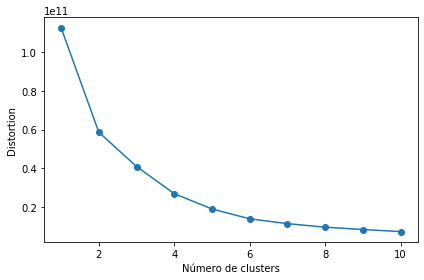

In [7]:
# Pelo método elbow encontrar o número ótimo de clusters
X = dataset_k_trimmed[features_3]
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('nome.png', dpi=300)
plt.show()

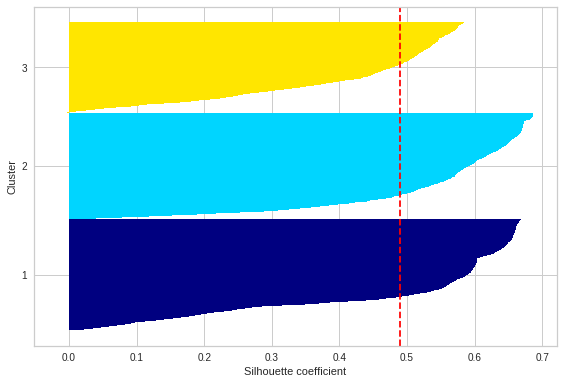

In [28]:
# Quantificar a qualidade dos clusters através do gráfico silhouette
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

X = dataset_k_trimmed[features_3]
kmeans_k3 = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km_3 = kmeans_k3.fit_predict(X)

cluster_labels_k3 = np.unique(y_km_3)
n_clusters = cluster_labels_k3.shape[0]
silhouette_vals = silhouette_samples(X, y_km_3, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels_k3):
    c_silhouette_vals = silhouette_vals[y_km_3 == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels_k3 + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('nome.png', dpi=300)
plt.show()

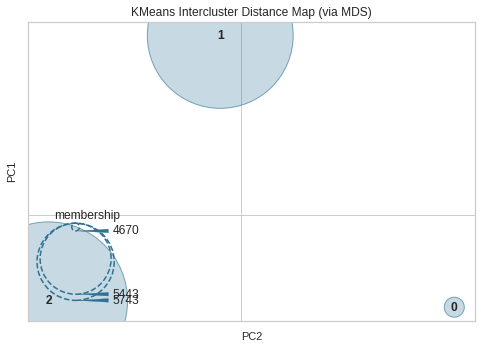

In [30]:
from yellowbrick.cluster import InterclusterDistance

model = KMeans(3)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

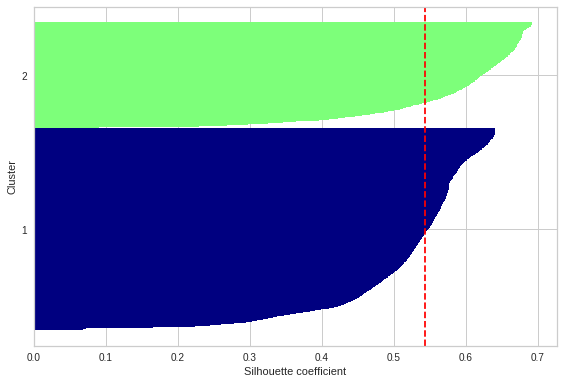

In [29]:
# Quantificar a qualidade dos clusters através do gráfico silhouette
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

X = dataset_k_trimmed[features_3]
kmeans_k2 = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km_k2 = kmeans_k2.fit_predict(X)

cluster_labels_k2 = np.unique(y_km_k2)
n_clusters = cluster_labels_k2.shape[0]
silhouette_vals = silhouette_samples(X, y_km_k2, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels_k2):
    c_silhouette_vals = silhouette_vals[y_km_k2 == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels_k2 + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('nome.png', dpi=300)
plt.show()

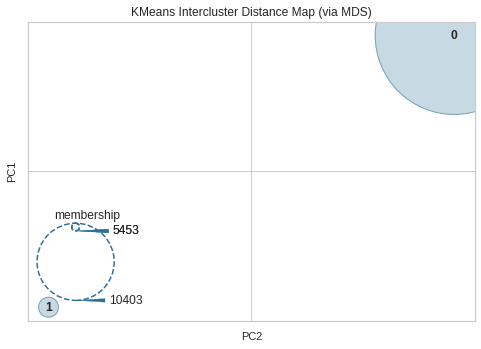

In [31]:
from yellowbrick.cluster import InterclusterDistance

model = KMeans(2)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [ ]:
X = dataset_k_trimmed[features_3]
kmeans_2 = KMeans(n_clusters=2)
kmeans_3 = KMeans(n_clusters=3)
y_kmeans_k2 = kmeans_2.fit_predict(X)
y_kmeans_k3 = kmeans_3.fit_predict(X)

In [ ]:
np.bincount(y_kmeans_k2)

In [ ]:
np.bincount(y_kmeans_k3)

In [ ]:
df_full = pd.DataFrame(data=dataset_k_trimmed[features_original], copy=True)
df_full['k2'] = y_kmeans_k2
df_full['k3'] = y_kmeans_k3
df_full

In [ ]:
df_full.to_csv(r'amostra_balanceada_4_cluster_full.csv', sep=';')